In [1]:
import os
import math
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torchvision import transforms as T
from torchmetrics.image import StructuralSimilarityIndexMeasure
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from model.models import *
from dataset.dataset import (
    device_checker,
    load_original_datasets,
    denormalize_tensor,
    denorm_mean,
    denorm_std,
    create_background_mask_otsu
)

Importing packages in models.py...
Importing packages in dataset.py...
GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping
Done importing in dataset.py.
Done importing in models.py.

Using device: mps



In [2]:
#root_dir = '/projects/dsci410_510/gz_hubble'
root_dir = '../data/gz_hubble'
weights_path = '../model/saved_models/CustomAutoencoder.pt'

# Initialize
device = device_checker()
dataset_dir = '../data/gz_hubble'  # UPDATE THIS
full_catalog, _, og_test_catalog = load_original_datasets(dataset_dir, return_og_catalogs=True)

# Optional sample
og_test_catalog = og_test_catalog.sample(1000)


Using device: mps

Loading original datasets from file...


In [ ]:
# ---------------------------
#  Test metrics computation
# ---------------------------

def compute_test_metrics(model, test_loader, early_stop=None):
    # Initialize SSIM metric
    ssim_metric_denorm = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_metric_denorm.reset()

    model.eval()
    with torch.inference_mode():
        for batch_idx, (noisy1, noisy2, clean1, clean2, mask1, mask2) in enumerate(test_loader):
            if early_stop is not None and batch_idx >= early_stop:
                break

            # Move data to device
            noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
            clean1, clean2 = clean1.to(device), clean2.to(device)
            mask1, mask2 = mask1.to(device), mask2.to(device)

            # Forward pass for both augmented views
            outputs1, _ = model(noisy1, return_latent=True)
            outputs2, _ = model(noisy2, return_latent=True)

            # Denormalize output and target images
            outputs_denorm1 = denormalize_tensor(outputs1, denorm_mean_tensor, denorm_std_tensor)
            targets_denorm1 = denormalize_tensor(clean1, denorm_mean_tensor, denorm_std_tensor)
            outputs_denorm2 = denormalize_tensor(outputs2, denorm_mean_tensor, denorm_std_tensor)
            targets_denorm2 = denormalize_tensor(clean2, denorm_mean_tensor, denorm_std_tensor)

            # Generate foreground/galaxy masks
            galaxy_mask1 = (1 - mask1).unsqueeze(1)
            galaxy_mask2 = (1 - mask2).unsqueeze(1)

            # Isolate the galaxy region
            outputs_galaxy1 = outputs_denorm1 * galaxy_mask1
            targets_galaxy1 = targets_denorm1 * galaxy_mask1
            outputs_galaxy2 = outputs_denorm2 * galaxy_mask2
            targets_galaxy2 = targets_denorm2 * galaxy_mask2

            # Update SSIM metric for both views
            ssim_metric_denorm.update(outputs_galaxy1, targets_galaxy1)
            ssim_metric_denorm.update(outputs_galaxy2, targets_galaxy2)

    # Compute overall SSIM score across both views
    test_ssim_score = ssim_metric_denorm.compute().item()

    return test_ssim_score


In [4]:
images_dir = os.path.join(root_dir, "images")
image_paths = og_test_catalog['file_loc'].tolist()
total_images = len(image_paths)

LATENT_DIM = 32  # Match up with value used in model
IMAGE_LOAD_BATCH_SIZE = 64

# Load model and weights
unet_model = UNetAutoencoder()
custom_model = CustomAutoencoder(
    activation_type='prelu',
    latent_dim=32
)
model = custom_model  # SET MODEL HERE
model.to(device)
model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
model.eval()

# Define transforms
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=denorm_mean, std=denorm_std)
])

# Initialize SSIM score metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
ssim_metric.reset()
ssim_scores = []

# Pre-allocate a single large tensor to hold all latent vectors
all_latents = torch.empty(total_images, LATENT_DIM, device=device)
start_idx = 0

with torch.no_grad():
    for i in tqdm(range(0, total_images, IMAGE_LOAD_BATCH_SIZE)):
        batch_files = image_paths[i: i + IMAGE_LOAD_BATCH_SIZE]
        batch_tensors = []

        for f in batch_files:
            with Image.open(f) as pil_img:
                pil_img = pil_img.convert("RGB")
                t_img = transform(pil_img)
            batch_tensors.append(t_img)

        batch_input = torch.stack(batch_tensors, dim=0).to(device)

        # Obtain reconstruction and latent vectors
        recon, latents = model(batch_input, return_latent=True)

        # Store latent representations
        end_idx = start_idx + latents.shape[0]
        all_latents[start_idx:end_idx] = latents
        start_idx = end_idx

        # Denormalize inputs and reconstructions
        batch_input_denorm = denormalize_tensor(batch_input)
        recon_denorm = denormalize_tensor(recon)

        # Create foreground/galaxy masks for each image in batch
        galaxy_masks = []
        for img in batch_input_denorm:
            background_mask = create_background_mask_otsu(img)
            galaxy_mask = 1 - background_mask
            galaxy_masks.append(galaxy_mask)
        galaxy_mask_tensor = torch.stack(galaxy_masks, dim=0).unsqueeze(1).to(device)

        # Apply galaxy mask to both target and reconstruction
        input_galaxy = batch_input_denorm * galaxy_mask_tensor
        recon_galaxy = recon_denorm * galaxy_mask_tensor

        # Compute SSIM only for galaxy region
        batch_ssim = ssim_metric(recon_galaxy, input_galaxy)
        ssim_scores.append(batch_ssim.item())


# Compute overall average SSIM across all batches
avg_ssim = sum(ssim_scores) / len(ssim_scores)
print("Average SSIM on test set galaxy regions:", np.round(avg_ssim, 3))

all_latents_np = all_latents.cpu().numpy()
print("NumPy array shape:", all_latents_np.shape)

100%|██████████| 16/16 [00:25<00:00,  1.57s/it]

Average SSIM on test set galaxy regions: 0.984
NumPy array shape: (1000, 32)


In [5]:
# ----------------
# PCA (Optional)
# ----------------

PCA = False

if PCA:
    pca_components = 16
    batch_size = 256

    ipca = IncrementalPCA(n_components=pca_components, batch_size=batch_size)

    num_samples = all_latents_np.shape[0]
    i = 0
    while i < num_samples:
        end = min(i + batch_size, num_samples)
        current_batch = all_latents_np[i:end]

        # Merge if the final batch is smaller than the PCA dimension
        if (end - i) < pca_components and i > 0:
            prev_start = i - batch_size
            merged_batch = np.concatenate([all_latents_np[prev_start:i], current_batch], axis=0)
            batch_gpu = np.asarray(merged_batch, dtype=np.float32)
            ipca.partial_fit(batch_gpu)
        else:
            batch_gpu = np.asarray(current_batch, dtype=np.float32)
            ipca.partial_fit(batch_gpu)

        i += batch_size

    # Transform the entire dataset into PCA space
    data_pca = np.asarray(all_latents_np, dtype=np.float32)
    all_latents = ipca.transform(data_pca)
else:
    all_latents = np.asarray(all_latents_np, dtype=np.float32)

In [6]:
# -------------------------
# HDBSCAN Clustering
# -------------------------
hdbscan_model = HDBSCAN(
    min_cluster_size=10
)
cluster_labels = hdbscan_model.fit_predict(all_latents)

unique_labels, counts = np.unique(cluster_labels, return_counts=True)

num_clusters = (unique_labels != -1).sum()
outlier_count = counts[unique_labels == -1].sum() if -1 in unique_labels else 0
outlier_fraction = outlier_count / cluster_labels.size

print(f"Number of clusters (excluding outliers): {num_clusters}")
print(f"Outliers count: {outlier_count} ({outlier_fraction:.2%} of all points)")

print("\nHDBSCAN cluster label -> count")
for label, count in zip(unique_labels, counts):
    print(f"{label:>3} -> {count}")

# Compute silhouette score on subset (excluding outliers)
sample_frac = 0.1
num_samples_subset = min(int(sample_frac * all_latents.shape[0]), 10000)
indices = np.random.permutation(all_latents.shape[0])[:num_samples_subset]

data_sample = all_latents[indices]
labels_sample = cluster_labels[indices]
mask = (labels_sample != -1)

hdbscan_sil_score = silhouette_score(data_sample[mask], labels_sample[mask])
print(f"\nHDBSCAN Silhouette score: {hdbscan_sil_score:.3f}")

# -------------------------
# K-means Clustering
# -------------------------

num_clusters = 6
kmeans_model = KMeans(n_clusters=num_clusters, n_init="auto")
kmeans_model.fit(all_latents)

# Retrieve cluster labels
kmeans_labels = kmeans_model.labels_

# Check cluster counts
unique_kmeans_labels, kmeans_counts = np.unique(kmeans_labels, return_counts=True)

print(f"\nKMeans with n_clusters={num_clusters}")
for label, count in zip(unique_kmeans_labels, kmeans_counts):
    print(f"Cluster {label} -> {count} points")

# Compute silhouette score
kmeans_sil_score = silhouette_score(all_latents, kmeans_labels)
print(f"\nKMeans Silhouette score: {kmeans_sil_score:.3f}")

/Users/logan/anaconda3/envs/dsci-full/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/logan/anaconda3/envs/dsci-full/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters (excluding outliers): 3
Outliers count: 110 (11.00% of all points)

HDBSCAN cluster label -> count
 -1 -> 110
  0 -> 153
  1 -> 5
  2 -> 732

HDBSCAN Silhouette score: 0.426

KMeans with n_clusters=6
Cluster 0 -> 360 points
Cluster 1 -> 164 points
Cluster 2 -> 3 points
Cluster 3 -> 338 points
Cluster 4 -> 13 points
Cluster 5 -> 122 points

KMeans Silhouette score: 0.320


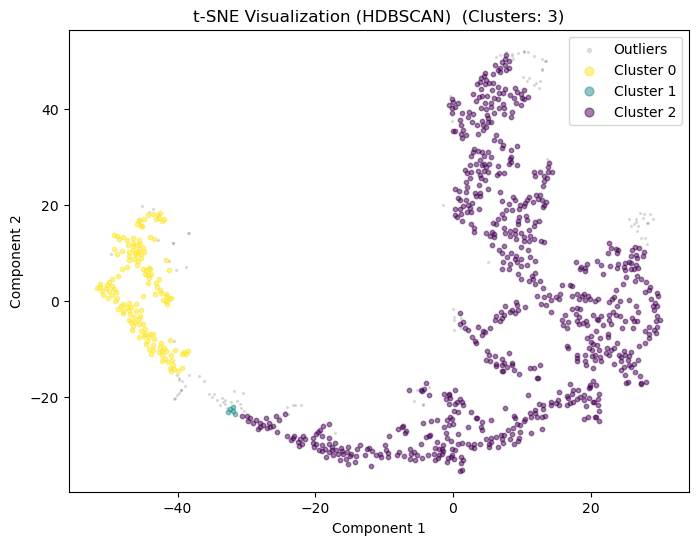

/Users/logan/anaconda3/envs/dsci-full/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


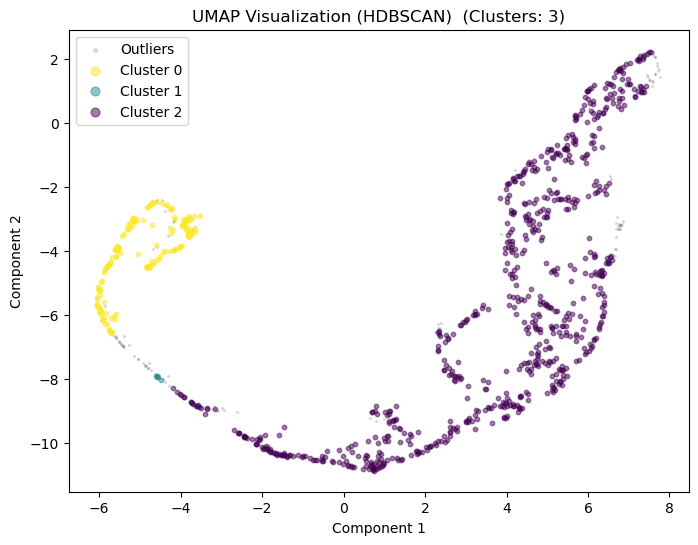

In [7]:
# ---------------------------
# Cluster Plotting Function
# ---------------------------

cluster_labels_hdbscan = hdbscan_model.labels_
cluster_labels_kmeans = kmeans_labels

def plot_clusters(data_2d, labels, title="", alpha_outliers=0.1, s_outliers=2, alpha_clusters=0.5, s_clusters=10):
    unique_labels = np.unique(labels)
    num_clusters = np.unique(labels[labels != -1]).size

    # Build a colormap for the clusters
    colors = plt.cm.viridis_r(np.linspace(0, 1, num_clusters))
    label_color_map = {lb: colors[i] for i, lb in
                       enumerate(sorted(unique_labels[unique_labels != -1]))}
    label_color_map[-1] = (0, 0, 0, 1)  # Outliers set to black

    plt.figure(figsize=(8, 6))

    for lb in unique_labels:
        mask = (labels == lb)

        # Use smaller size and lower alpha for outliers
        plot_alpha = alpha_outliers if lb == -1 else alpha_clusters
        plot_size = s_outliers if lb == -1 else s_clusters

        plt.scatter(
            data_2d[mask, 0],
            data_2d[mask, 1],
            c=[label_color_map[lb]],
            label=f"Cluster {lb}" if lb != -1 else "Outliers",
            s=plot_size,
            alpha=plot_alpha
        )

    plt.title(f"{title}  (Clusters: {num_clusters})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(markerscale=2)
    plt.show()


# ------------------------------------
#  t-SNE Visualization of Clusters
# ------------------------------------


"""tsne = TSNE(
    n_components=2,
    perplexity=50,
    n_neighbors=250,
    learning_rate=20,
    n_iter=3000,
    verbose=False
)"""

tsne = TSNE(
    n_components=2,
    max_iter=3000,
    verbose=False
)
data_2d_tsne = tsne.fit_transform(all_latents)

plot_clusters(data_2d_tsne, cluster_labels_hdbscan, title="t-SNE Visualization (HDBSCAN)")
# plot_clusters(data_2d_tsne, cluster_labels_kmeans, title="t-SNE Visualization (K-means)")

# ----------------------------------
#  UMAP Visualization of Clusters
# ----------------------------------

"""umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    learning_rate=0.5,
    n_epochs=3000,
    verbose=False
)"""

umap_2d = UMAP(
    n_components=2,
    n_neighbors=30,
    n_epochs=3000,
    verbose=False
)
data_2d_umap = umap_2d.fit_transform(all_latents)

plot_clusters(data_2d_umap, cluster_labels_hdbscan, title="UMAP Visualization (HDBSCAN)")
# plot_clusters(data_2d_umap, cluster_labels_kmeans, title="UMAP Visualization (K-means)")

In [ ]:
# -------------------------------------
#  3-D UMAP Visualization of Clusters
# -------------------------------------

"""umap_3d = UMAP(
    n_components=3,
    n_neighbors=30,
    learning_rate=0.5,
    n_epochs=3_000,
    verbose=False
    )"""

umap_3d = UMAP(
    n_components=3,
    verbose=False
    )

data_3d = umap_3d.fit_transform(all_latents)


# Create plot
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=data_3d[:, 0],
    y=data_3d[:, 1],
    z=data_3d[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=cluster_labels_hdbscan,
        colorscale='Viridis',
        opacity=0.25
    ),
    name='Data points'
))

fig.update_layout(
    title="Interactive 3-D UMAP Visualization",
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)

fig.show()


Showing samples from cluster 0...


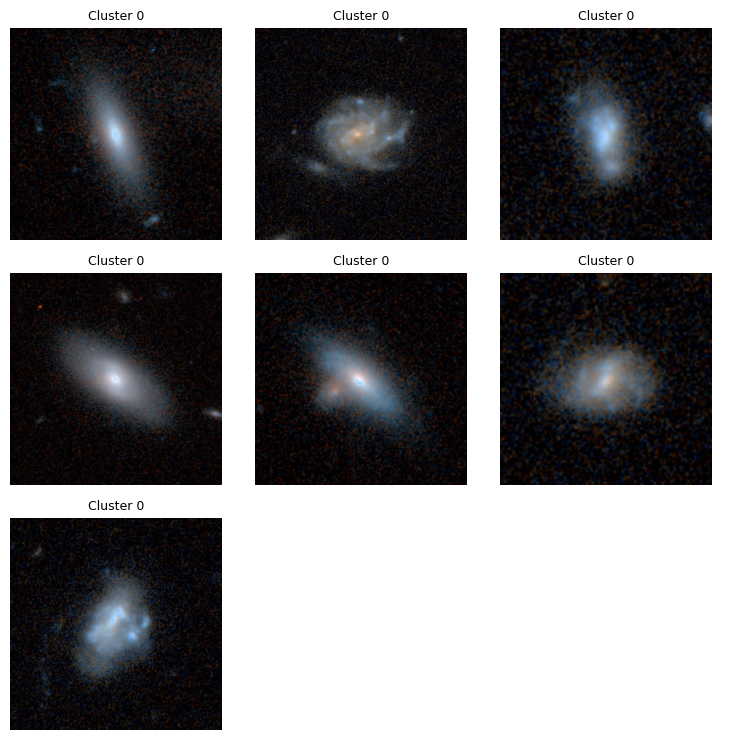


Showing samples from cluster 1...


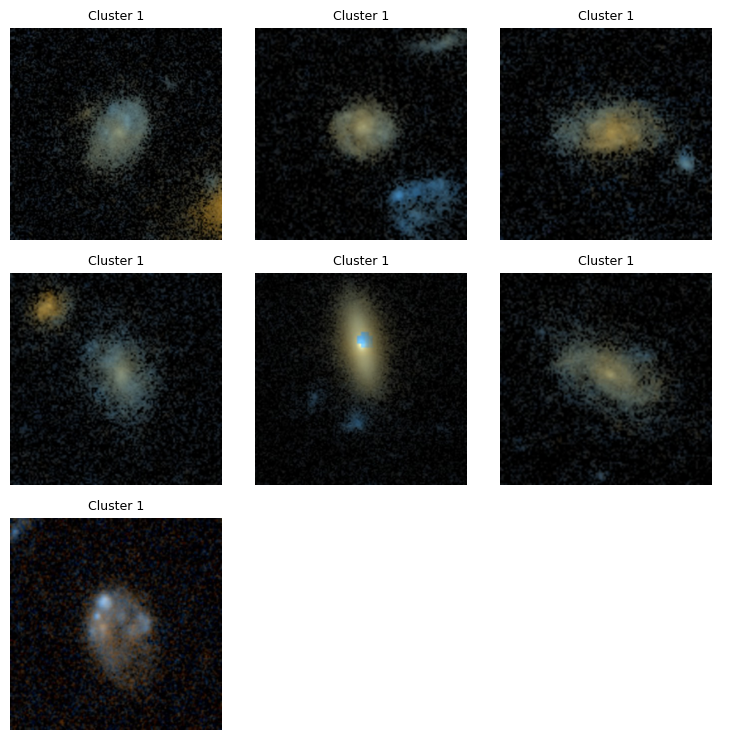


Showing samples from cluster 2...


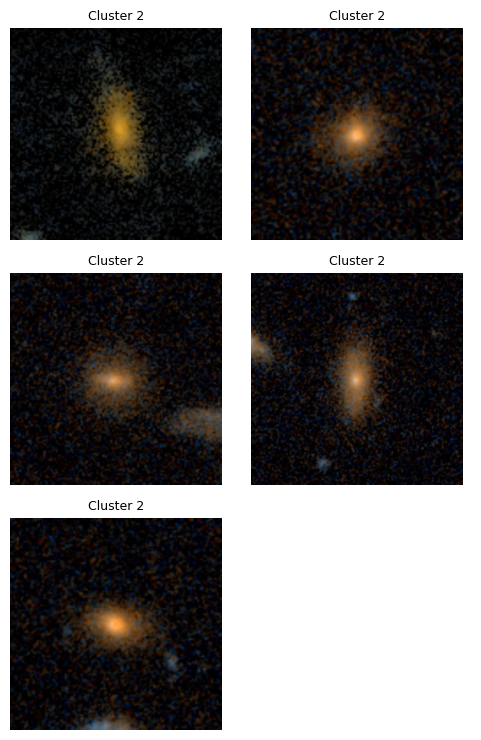


Showing samples from cluster 3...


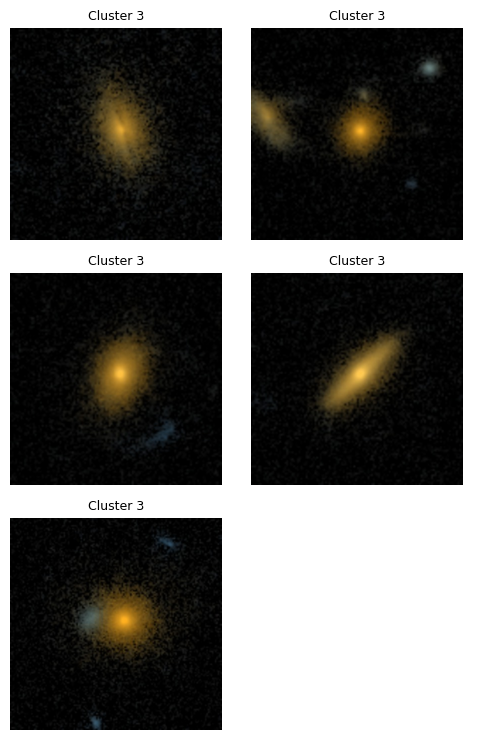


Showing samples from cluster 4...


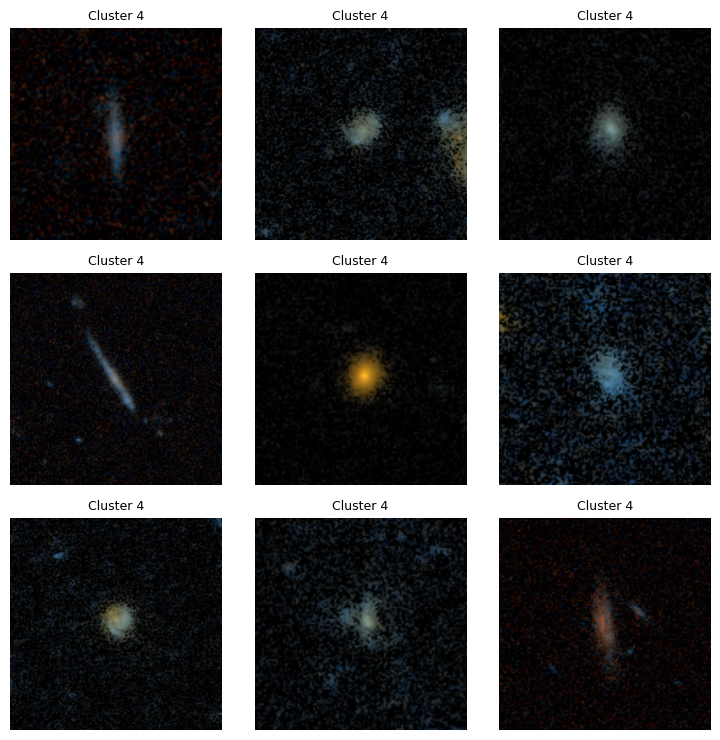


Showing samples from cluster 5...
No samples found for cluster 5.

Showing samples from cluster 6...
No samples found for cluster 6.


In [59]:
# -----------------------------------------------
# Function for Visualizing Cluster Example Images
# -------------------------------------------------

def plot_cluster_samples(catalog, cluster_labels, cluster_id, n=9, image_col="file_loc"):
    # Grab indices
    idxs = [i for i, lbl in enumerate(cluster_labels) if lbl == cluster_id]
    if not idxs:
        print(f"No samples found for cluster {cluster_id}.")
        return

    # Convert indices into a catalog of just that cluster
    cluster_catalog = catalog.iloc[idxs].copy()

    # Randomly sample up to n images
    if len(cluster_catalog) > n:
        cluster_catalog = cluster_catalog.sample(n)
    else:
        cluster_catalog = cluster_catalog.sample(frac=1.0)

    # Initialize layout
    num_samples = len(cluster_catalog)
    rows = int(math.ceil(num_samples ** 0.5))
    cols = int(math.ceil(num_samples / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 2.5 * rows))
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Plot each sample
    for ax, (_, row) in zip(axes, cluster_catalog.iterrows()):
        file_path = row[image_col]
        try:
            with Image.open(file_path) as img:
                ax.imshow(img)
            ax.set_title(f"Cluster {cluster_id}", fontsize=9)
        except Exception as e:
            print(f"Error loading '{file_path}': {e}")
        ax.axis("off")
    for leftover_ax in axes[num_samples:]:
        leftover_ax.axis("off")

    plt.tight_layout()
    plt.show()


# -------------------------------
# Visualizing Cluster Examples
# -------------------------------

for cluster_id in range(7):
    print(f"\nShowing samples from cluster {cluster_id}...")
    plot_cluster_samples(
        catalog=og_test_catalog,
        cluster_labels=cluster_labels_hdbscan,
        cluster_id=cluster_id,
        n=9,
        image_col="file_loc"
    )